# CS145: Project 2 | Me, in Texts

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Kabir Jolly, kjolly*

## Project Overview

---

This project explores my digital footprint, attempting to better uncover who I am and what my relationships look like based on the largest digital repository of data I have on myself, my text messages.

The main question I am hoping to answer is:

*   Has the nature of the communication I have with my online relationships changed over the past decade (ages 12 till 22)?


 Some supporting questions that come up in the event to uncover the central answer include:

*   Who are the top contacts I've communicated with throughout time?
*   Has my communication style changed over the years?
*   What individual and group communications drive the bulk of my online interactions?

---


## Analysis of Dataset

---

Dataset overview and explanation:
  * File size: 1.09GB (original .db file)
  * Relevant tables: mainTable (constructed via INSERT query from the below)
    * `message` Relevant text message information with ROWID primary key (PK `rowid` and FK `handle_id`-> `handle.rowid`)
    * `chat_message_join` Join table between `message` and `chat` (FK `message_id`-> `message.row_id` and `chat_id`->`chat.rowid)
    * `chat_handle_join` Join table between chats and handles (chat participants) (FK `chat_id`-> `chat.row_id` and `chat_id`->`chat.rowid)
    * `handle` Represents contacts and identifies group chats or DMs (FK `message.handle_id`-> `chat_handle_join.handle_id`)
    * `chat` Contains metadata about DM and group chats

Data issues:
*   There was a lot of empty message data which I realized was not simply found in the raw string entry. I found a script online that takes it from the AttributedBody column and fills in the missing text (formatted as NSAttributedBody, a MacOS typing that needs to be parsed). This step nearly doubled the amount of data I had at my disposal for the project. Credit for this quick fix is found [here](https://apple.stackexchange.com/questions/421665/how-specificially-do-i-read-a-chat-db-file).
*   For uploading to big query, I decided to turn the .db file into a Parquet to easily read it without the issues of using a delimiter-based file format (as that was creating inconsistencies in the file) and so I ran JOINs and SELECTs to create my working dataset window (1.09GB -> 107MB of relevant data). The code I used is as follows:


```
INSERT INTO mainTable (rowid, ThreadId, IsFromMe, FromPhoneNumber, ToPhoneNumber, Service, TextDate, MessageText, AttributedBody, RoomName, ContactName, AssociatedMessageType, GUID, AssociatedMessageGUID)
  SELECT
      m.rowid,
      COALESCE(m.cache_roomnames, h.id) AS ThreadId,
      m.is_from_me AS IsFromMe,
      CASE
          WHEN m.is_from_me = 1 THEN 'Me'
          ELSE h.id
      END AS FromPhoneNumber,
      CASE
          WHEN m.is_from_me = 0 THEN 'Me'
          ELSE COALESCE(h2.id, h.id)
      END AS ToPhoneNumber,
      m.service AS Service,
      DATETIME((m.date / 1000000000) + 978307200, 'unixepoch', 'localtime') AS TextDate,
      m.text AS MessageText,
      m.attributedBody AS AttributedBody,
      c.display_name AS RoomName,
      NULL AS ContactName,
      m.associated_message_type AS AssociatedMessageType,
      m.guid AS GUID,
      m.associated_message_guid AS AssociatedMessageGUID
  FROM
      message AS m
      LEFT JOIN chat_message_join AS cmj ON m.rowid = cmj.message_id
      LEFT JOIN chat_handle_join AS chj ON cmj.chat_id = chj.chat_id
      LEFT JOIN handle AS h ON
          (m.cache_roomnames IS NOT NULL AND h.rowid = m.handle_id) OR
          (m.cache_roomnames IS NULL AND h.rowid = chj.handle_id)
      LEFT JOIN chat AS c ON m.cache_roomnames = c.room_name
      LEFT JOIN handle AS h2 ON chj.handle_id = h2.rowid
  WHERE NOT EXISTS (
      SELECT 1 FROM mainTable WHERE mainTable.rowid = m.rowid
  )
  GROUP BY m.rowid
  ORDER BY
      m.date DESC;
```

----

## Supplementary Data

For the supplementary data, I self-created 2 datasets that were joined to my main text message table.



1.   First, I used the `Twitter-roBERTa-base for Sentiment Analysis` model from HuggingFace to map texts to their sentiments (scores from 0 to 1 measuring the classwise magnitude of Positive, Negative, and Neutral). I began by using the `VADER SentimentIntensityAnalyzer` but it struggled to pick up the nuance we see in text, the roBERTa that was modeled upon Twitter data lent itself to far more accurate outcomes due to being trained on a much more representative dataset (high correlation between slang, emojis, figures of speech, etc in Texts and Tweets).
2.   Second, I used the `gender-guesser` API to generate `{name:gender}` mappings for the contact names I have saved in my iMessage data. It is not extraordinarily accurate, given that it only uses first name, and has been studied to have a Western name bias due to imbalanced training data, but it does a good enough generalization job for many names (lots of unknowns, though).

Note: While I totally understand that this data is created using AI models, I plan to treat them as the "ground truth" for visualization and analysis. My intuitions and hypothesis were supported, or there were logical explanations for the results that we see below, so I thought using this as supplementary information, rather than very declarative supplementary data, was so much more interesting for my project.

**How does the supplementary table enrich the dataset and insights?**
This data was a perfect add-on to the limitations I detailed in my conclusion of Project 1. I discussed how querying the data declaratively, while interesting itself, lacked the ability to capture semantic nuance (sentiment, behavior, differences between spoken/typed language) despite this being so crucial to detailing online communication. By joining the `text-sentiments` table, we can qualify how sentiments are changed over time, see if they mirror how I felt IRL, and also compare the prevailing strength of different sentiments stratified by person, etc. By joining the `text-author-genders` table, we can perform interesting analyses that compare and contrast the communication styles across genders (constrained to Male and Female, for the scope and purposes of this project). None of this data is readily available within the data, or as external data sources, but due to how crucial I view it to be for proper analyses, I worked to create them myself.

### Creating `text-sentiments`

In [ ]:
# DON'T RUN -- This cell was run in a local env
# This code is provided for REFERENCE ONLY
import pandas as pd
from transformers import pipeline
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

all_messages = pd.read_parquet('messages.parquet')

def preproc_table(df, only_dms=False, no_reactions=False):
    cols_to_keep = [
        "rowid",
        "MessageText",
        "AssociatedMessageType",
        "RoomName"
    ]

    processed_table = df[cols_to_keep].copy()
    processed_table = processed_table[processed_table['MessageText'] != '']

    if only_dms:
        processed_table = processed_table[processed_table["RoomName"].isna()]

    if no_reactions:
        processed_table = processed_table[processed_table["AssociatedMessageType"] == 0]

    return processed_table

roberta_sentiment_table = preproc_table(all_messages, only_dms=True, no_reactions=True)

sentiment_pipeline = pipeline(
   "sentiment-analysis",
   model="cardiffnlp/twitter-roberta-base-sentiment",
   top_k=None,
   max_length=512,
   truncation=True
)

# Process in single batch mode
texts = roberta_sentiment_table['MessageText'].tolist()
batch_size = 64

# Single process with batching
results = []
for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
   batch = texts[i:i + batch_size]
   batch_results = sentiment_pipeline(list(batch), padding=True, truncation=True)
   results.extend(batch_results)

# Process results with correct label mapping
processed_results = []
for result in results:
   scores = {'LABEL_0': 0, 'LABEL_1': 0, 'LABEL_2': 0}
   for r in result:
       scores[r['label']] = r['score']
   processed_results.append(scores)

# Add to dataframe
roberta_sentiment_table['negative'] = [r['LABEL_0'] for r in processed_results]
roberta_sentiment_table['neutral'] = [r['LABEL_1'] for r in processed_results]
roberta_sentiment_table['positive'] = [r['LABEL_2'] for r in processed_results]

# Add sentiment label
label_map = {
   'LABEL_0': 'Negative',
   'LABEL_1': 'Neutral',
   'LABEL_2': 'Positive'
}
roberta_sentiment_table['sentiment'] = [label_map[max(result, key=lambda x: x['score'])['label']] for result in results]
roberta_sentiment_table.to_parquet('roberta_sentiment_scores.parquet')

### Creating `text-author-genders`

In [ ]:
# DON'T RUN -- This cell was run in a local env
# This code is provided for REFERENCE ONLY
import gender_guesser.detector as gender
import pandas as pd

all_messages = pd.read_parquet('messages.parquet')
all_messages = all_messages[~all_messages['ContactName'].isna()]

detector = gender.Detector()

unique_contacts = all_messages['ContactName'].unique()
valid_contacts = [name for name in unique_contacts
                 if not (str(name).startswith('+') or
                        '@' in str(name) or
                        str(name).isdigit())]

def get_gender(full_name):
    first_name = full_name.split()[0]
    gender_prediction = detector.get_gender(first_name)

    if gender_prediction in ['male', 'mostly_male']:
        return 'male'
    elif gender_prediction in ['female', 'mostly_female']:
        return 'female'
    else:
        return 'unknown'

gender_table = pd.DataFrame({
    'ContactName': valid_contacts,
    'gender': [get_gender(name) for name in valid_contacts]
})

gender_table.to_parquet('contact_genders.parquet')

## Data Exploration

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-project1-receipts"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
%%bigquery --project $project_id
-- Run two JOINs to create my main table for future analyses

CREATE OR REPLACE TABLE `cs145-project1-receipts.texts_dataset.texts_with_sentiment_gender` AS
SELECT
  t.rowid,
  t.IsFromMe,
  t.TextDate,
  t.MessageText,
  t.ContactName,
  t.AssociatedMessageType,
  t.GUID,
  t.AssociatedMessageGUID,
  s.negative,
  s.positive,
  s.neutral,
  g.gender
FROM
  `cs145-project1-receipts.texts_dataset.texts` t
-- keep all texts for which we computed sentiments
JOIN
  `cs145-project1-receipts.texts_dataset.text-sentiments` s
ON
  t.rowid = s.rowid
-- show null for gender if it does not exist for a contact, but keep left table
LEFT JOIN
  `cs145-project1-receipts.texts_dataset.text-author-genders` g
ON t.ContactName = g.ContactName

Query is running:   0%|          |

""


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from datetime import datetime
import numpy as np

In [ ]:
%%bigquery hourly_patterns_df --project $project_id

SELECT
  EXTRACT(HOUR FROM TIMESTAMP(TextDate)) as hour,
  gender,
  COUNT(*) as message_count,
  AVG(positive) as avg_positive,
  AVG(negative) as avg_negative,
  AVG(neutral) as avg_neutral
FROM
  `cs145-project1-receipts.texts_dataset.texts_with_sentiment_gender`
WHERE
  gender IN ('male', 'female')
GROUP BY
  hour, gender
ORDER BY
  hour

Query is running:   0%|          |

Downloading:   0%|          |

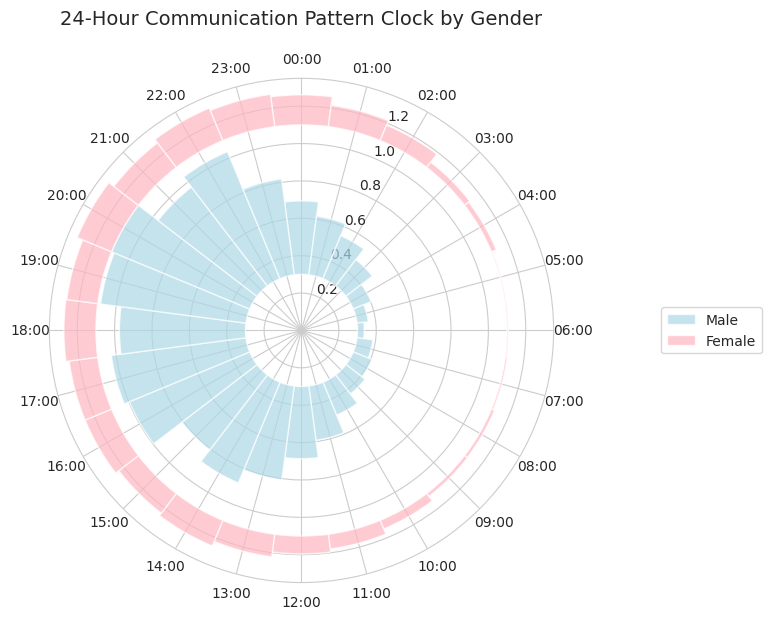

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

# Convert hours to radians (24 hours -> 2π)
hours = hourly_patterns_df['hour'].unique()
theta = [h * 2 * np.pi / 24 for h in hours]

# Create bars for each gender
width = 2 * np.pi / 24
inner_radius = 0.3

# Get data for each gender
male_data = hourly_patterns_df[hourly_patterns_df['gender'] == 'male']
female_data = hourly_patterns_df[hourly_patterns_df['gender'] == 'female']

# Normalize message counts
max_count = hourly_patterns_df['message_count'].max()
bar_scale = 0.8

ax.bar(theta, male_data['message_count'] * bar_scale / max_count,
       width=width, bottom=inner_radius,
       color='lightblue', alpha=0.7, label='Male')

ax.bar(theta, female_data['message_count'] * bar_scale / max_count,
       width=width, bottom=inner_radius + 0.8,
       color='lightpink', alpha=0.7, label='Female')

ax.set_title('24-Hour Communication Pattern Clock by Gender', pad=20, fontsize=14)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')

hour_labels = [f'{hour:02d}:00' for hour in hours]
ax.set_xticks(theta)
ax.set_xticklabels(hour_labels)
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center left')
plt.tight_layout()
plt.show()

This "Clock Plot" shows the distribution and frequency, stratified by gender, at which I send text messages. I found it to be interesting as it roughly mirrors my sleeping patterns, with a lack of texts exchanged between ~2am-10am. It also confirms how as a male myself, I have a good number of more male friends and thus higher frequency of interactions on this front consistently across time. These are currently standardized for the sake of visualization but in my original histogram (before making it circular) I found even higher visual distinction between my rate of messaging between guys and girls. I also found it interesting that my online exchanges peak (amongst both genders, in fact) at 8pm -- not a riveting or particularly explainable result, just something I had not anticipated. Perhaps my phone usage is more extensive right after dinner time, at large.

Citation: I used Claude to convert this to a clock format after initially just plotting it has a histogram like distribution of frequencies over time. I had the idea for this but my polar coordinate pre-calculus had left me so I got some help!

In [ ]:
%%bigquery sentiment_df --project $project_id

SELECT
  TextDate,
  IsFromMe,
  positive,
  negative,
  neutral
FROM
  `cs145-project1-receipts.texts_dataset.texts_with_sentiment_gender`
ORDER BY
  TextDate

Query is running:   0%|          |

Downloading:   0%|          |

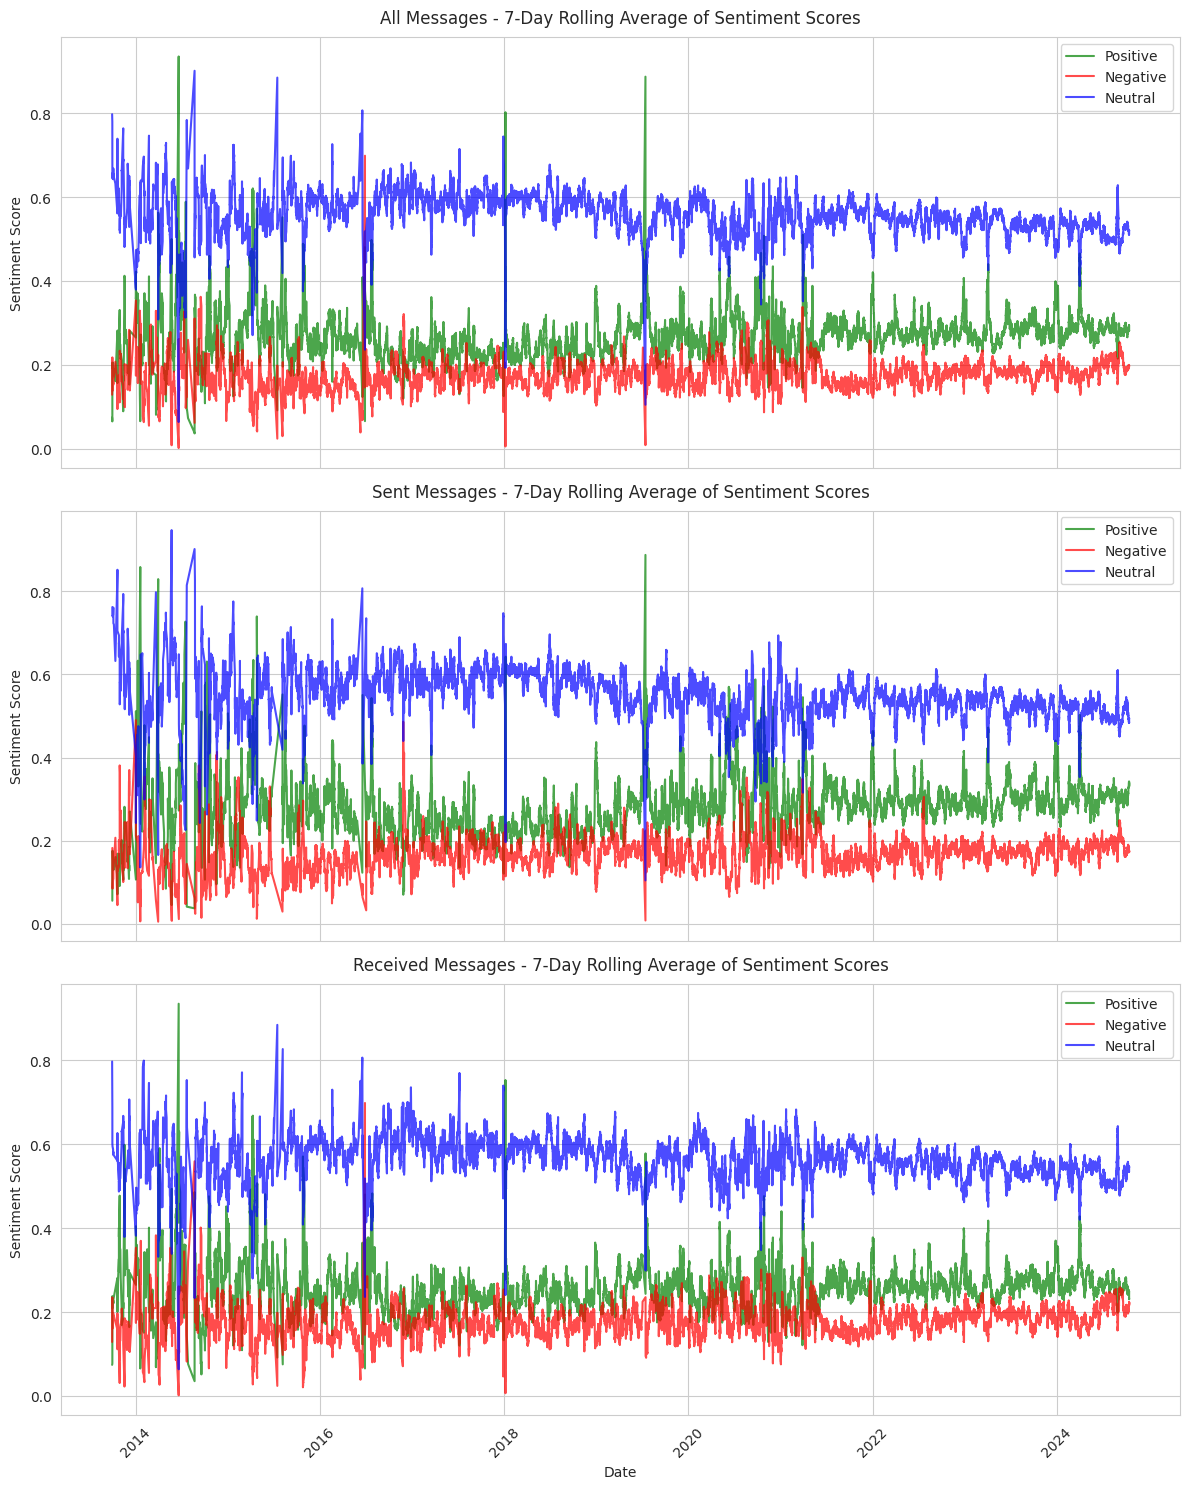

In [ ]:
# Convert TextDate to datetime if it isn't already
sentiment_df['TextDate'] = pd.to_datetime(sentiment_df['TextDate'])

# Create separate dataframes for sent and received messages
sent_msgs = sentiment_df[sentiment_df['IsFromMe'] == 1].set_index('TextDate')
received_msgs = sentiment_df[sentiment_df['IsFromMe'] == 0].set_index('TextDate')
all_msgs = sentiment_df.set_index('TextDate')

# Calculate 7-day rolling averages
sent_rolling = sent_msgs[['positive', 'negative', 'neutral']].rolling('7D').mean()
received_rolling = received_msgs[['positive', 'negative', 'neutral']].rolling('7D').mean()
all_rolling = all_msgs[['positive', 'negative', 'neutral']].rolling('7D').mean()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# all msgs
ax1.plot(all_rolling.index, all_rolling['positive'], label='Positive', color='green', alpha=0.7)
ax1.plot(all_rolling.index, all_rolling['negative'], label='Negative', color='red', alpha=0.7)
ax1.plot(all_rolling.index, all_rolling['neutral'], label='Neutral', color='blue', alpha=0.7)
ax1.set_title('All Messages - 7-Day Rolling Average of Sentiment Scores', pad=10)
ax1.set_ylabel('Sentiment Score')
ax1.grid(True)
ax1.legend()

# sent msgs
ax2.plot(sent_rolling.index, sent_rolling['positive'], label='Positive', color='green', alpha=0.7)
ax2.plot(sent_rolling.index, sent_rolling['negative'], label='Negative', color='red', alpha=0.7)
ax2.plot(sent_rolling.index, sent_rolling['neutral'], label='Neutral', color='blue', alpha=0.7)
ax2.set_title('Sent Messages - 7-Day Rolling Average of Sentiment Scores', pad=10)
ax2.set_ylabel('Sentiment Score')
ax2.grid(True)
ax2.legend()

# received msgs
ax3.plot(received_rolling.index, received_rolling['positive'], label='Positive', color='green', alpha=0.7)
ax3.plot(received_rolling.index, received_rolling['negative'], label='Negative', color='red', alpha=0.7)
ax3.plot(received_rolling.index, received_rolling['neutral'], label='Neutral', color='blue', alpha=0.7)
ax3.set_title('Received Messages - 7-Day Rolling Average of Sentiment Scores', pad=10)
ax3.set_xlabel('Date')
ax3.set_ylabel('Sentiment Score')
ax3.grid(True)
ax3.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This line graph uses week-by-week sentiment score averages to show how my sentiments may have changed over time. With a high volume of data, the trends ended up remaining fairly stagnant over time, but I would like to call out a few neat findings. For the purposes of analyses, I disregarded some of the earlier data (start-2016, lots of missing data, fewer amounts of data, and I was in middle school so I'm sure there was high variance), and focused on some later trends.


1.   Positive sentiment in my messages, almost entirely across the board, was higher than negative sentiment. This was true for both messages I sent and messages I received.
2.   All metrics were fairly comparable with overall average sentiment scores. However, the biggest discrepancy was found in an almost 3 point difference between the positivity sentiment scores in messages I sent versus messages I received. I hope to keep this up.
3.   There was a fascinating spike towards the end of 2019, and I think that can be attributed to a massive influx of texts coming in to congratulate me for my acceptance to Stanford!
4.   During my online freshman year -- which is around 2020.5-2021.5 -- (when I was in low spirits, and suffered mental health effects of the pandemic as a student isolating at home, missing the college experience), the gap between positive and negative sentiment is the lowest. This immediately turns after getting to Stanford the summer after freshman year (June 2021) and the gap is consistently the widest it's been, even compared to pre-college!






In [ ]:
%%bigquery --project $project_id

SELECT
 COUNTIF(gender = "male") as num_texts_from_male,
 COUNTIF(gender = "female") as num_texts_from_female,
 ROUND(COUNTIF(gender = "male") * 100.0 / (COUNTIF(gender = "male") + COUNTIF(gender = "female")), 2) as male_percentage,
 ROUND(COUNTIF(gender = "female") * 100.0 / (COUNTIF(gender = "male") + COUNTIF(gender = "female")), 2) as female_percentage
FROM
 `cs145-project1-receipts.texts_dataset.texts_with_sentiment_gender`
WHERE
 gender IN ('male', 'female')

Query is running:   0%|          |

Downloading:   0%|          |

,num_texts_from_male,num_texts_from_female,male_percentage,female_percentage
0,140580,35963,79.63,20.37


In [ ]:
%%bigquery sentiment_by_gender_df --project $project_id

SELECT
 gender,
 positive,
 negative,
 neutral
FROM
 `cs145-project1-receipts.texts_dataset.texts_with_sentiment_gender`
WHERE
 gender IN ('male', 'female')

Query is running:   0%|          |

Downloading:   0%|          |

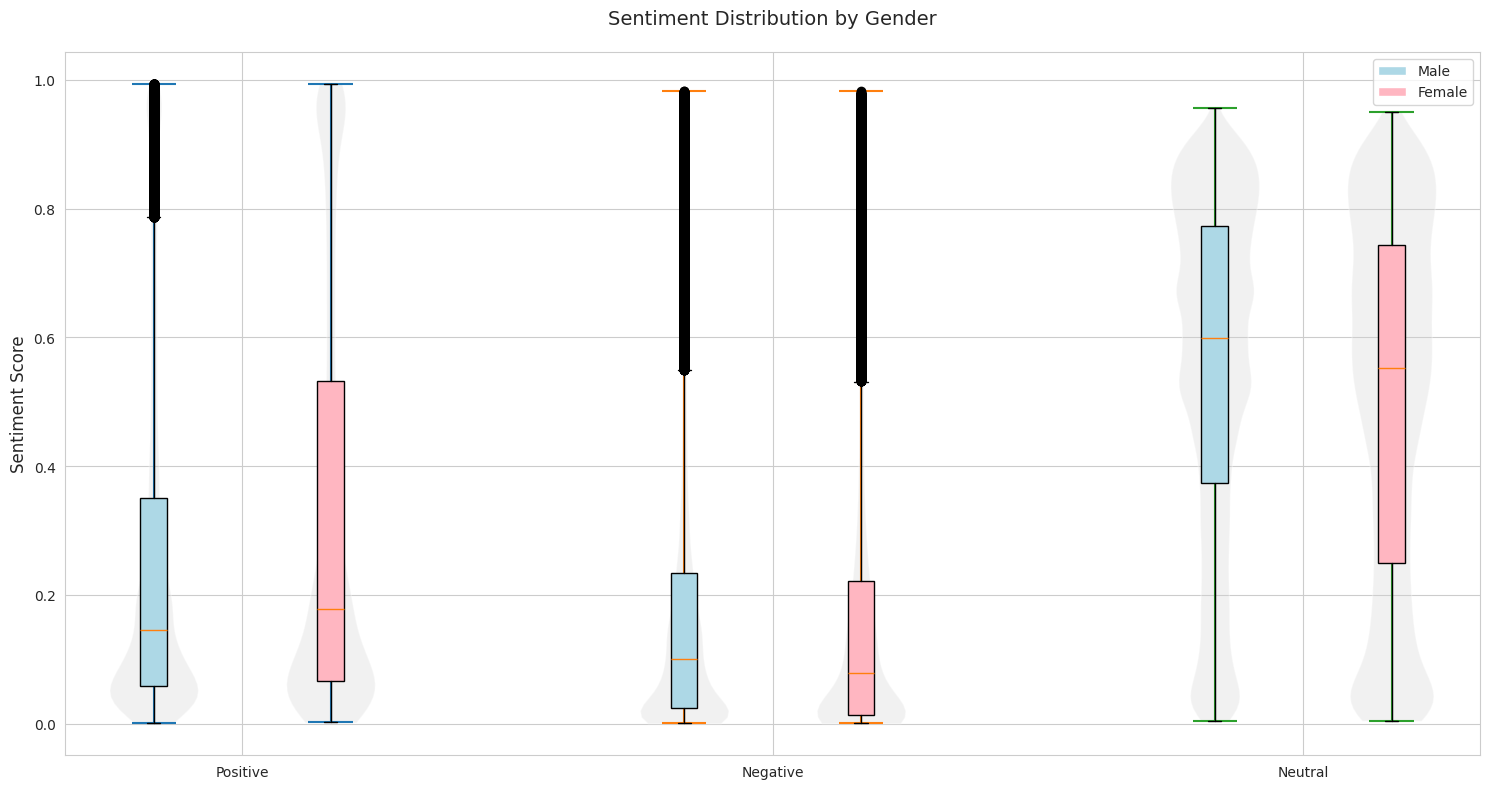

In [ ]:
plt.figure(figsize=(15, 8))

positions = [1, 2, 4, 5, 7, 8]
vp1 = plt.violinplot([sentiment_by_gender_df[sentiment_by_gender_df['gender']=='male']['positive'],
                     sentiment_by_gender_df[sentiment_by_gender_df['gender']=='female']['positive']],
                     positions=[1, 2])
vp2 = plt.violinplot([sentiment_by_gender_df[sentiment_by_gender_df['gender']=='male']['negative'],
                     sentiment_by_gender_df[sentiment_by_gender_df['gender']=='female']['negative']],
                     positions=[4, 5])
vp3 = plt.violinplot([sentiment_by_gender_df[sentiment_by_gender_df['gender']=='male']['neutral'],
                     sentiment_by_gender_df[sentiment_by_gender_df['gender']=='female']['neutral']],
                     positions=[7, 8])

for vp in [vp1, vp2, vp3]:
    for pc in vp['bodies']:
        pc.set_facecolor('lightgray')
        pc.set_alpha(0.3)

bp1 = plt.boxplot([sentiment_by_gender_df[sentiment_by_gender_df['gender']=='male']['positive'],
                  sentiment_by_gender_df[sentiment_by_gender_df['gender']=='female']['positive']],
                  positions=[1, 2], patch_artist=True)
bp2 = plt.boxplot([sentiment_by_gender_df[sentiment_by_gender_df['gender']=='male']['negative'],
                  sentiment_by_gender_df[sentiment_by_gender_df['gender']=='female']['negative']],
                  positions=[4, 5], patch_artist=True)
bp3 = plt.boxplot([sentiment_by_gender_df[sentiment_by_gender_df['gender']=='male']['neutral'],
                  sentiment_by_gender_df[sentiment_by_gender_df['gender']=='female']['neutral']],
                  positions=[7, 8], patch_artist=True)

colors = ['lightblue', 'lightpink']
for bp in [bp1, bp2, bp3]:
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

plt.title('Sentiment Distribution by Gender', fontsize=14, pad=20)
plt.ylabel('Sentiment Score', fontsize=12)
plt.grid(True, axis='y')
plt.xticks([1.5, 4.5, 7.5], ['Positive', 'Negative', 'Neutral'])


legend_elements = [Patch(facecolor='lightblue', label='Male'),
                  Patch(facecolor='lightpink', label='Female')]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

Here I created box and violin plots to show the distribution of sentiments by gender. This was a useful analyses because it compared the sentiments stratified by population and also quantifies the variance and averages across positive and negative messages (and also neutral, but these are less interesting to me).

I ended up finding that results for negative messages and neutral messages were very similar between genders, but found an interesting comparison within the positive messages. It appears that messages exchanged with females have a wider concentration between the median and 0.75 quartile mark, meaning that the messages are more positive at first glance. However, much of the discrepancy can be accounted for in our outliers, where we find it to be the case that there are many highly positive outliers, to the point at which it escaped the IQR of the Male-Positive boxplot, clustered at the highly positive end of sentiment scores. As such, my data may show that the messages I sent to, and receive from Females skew more positively, but when I do send or receive a positive message from a Male, it is more extreme.

Citation: I used Claude to help with colors (I was unfamiliar with matplotlib `Patches` and to also add in the violin plot overlaying the boxplots I had originally created.

## Baseline and Data Prediction

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `cs145-project1-receipts.texts_dataset.messages_with_reactions` AS
WITH reactions_mapping AS (
  SELECT
    SUBSTR(AssociatedMessageGUID, 5) as original_message_guid,
    CASE AssociatedMessageType
      WHEN 2000 THEN 'love'
      WHEN 2001 THEN 'like'
      WHEN 2002 THEN 'dislike'
      WHEN 2003 THEN 'laugh'
      WHEN 2004 THEN 'emphasize'
      WHEN 2005 THEN 'question'
    END as reaction_type
  FROM `cs145-project1-receipts.texts_dataset.texts`
  WHERE AssociatedMessageType IN (2000, 2001, 2002, 2003, 2004, 2005)
)
SELECT
  t.rowid,  -- Add this for joining later
  t.IsFromMe,
  TIMESTAMP(t.TextDate) as TextDate,
  t.MessageText,
  t.RoomName,
  t.ContactName,
  s.positive,
  s.negative,
  s.neutral,
  g.gender,
  r.reaction_type as label,
  -- Text Features
  LENGTH(t.MessageText) as message_length,
  ARRAY_LENGTH(SPLIT(t.MessageText, ' ')) as word_count,
  CASE WHEN REGEXP_CONTAINS(t.MessageText, r'[?]') THEN 1 ELSE 0 END as has_question,
  CASE WHEN REGEXP_CONTAINS(t.MessageText, r'[!]') THEN 1 ELSE 0 END as has_exclamation,
  LENGTH(REGEXP_REPLACE(t.MessageText, r'[^\p{Emoji_Presentation}\p{Extended_Pictographic}]', '')) as emoji_count,
  -- DateTime Features
  EXTRACT(HOUR FROM TIMESTAMP(t.TextDate)) as hour_of_day,
  EXTRACT(DAYOFWEEK FROM TIMESTAMP(t.TextDate)) as day_of_week,
  CASE WHEN EXTRACT(DAYOFWEEK FROM TIMESTAMP(t.TextDate)) IN (1, 7) THEN 1 ELSE 0 END as is_weekend,
  EXTRACT(MONTH FROM TIMESTAMP(t.TextDate)) as month
FROM `cs145-project1-receipts.texts_dataset.texts` t
INNER JOIN reactions_mapping r
  ON t.GUID = r.original_message_guid
LEFT JOIN `cs145-project1-receipts.texts_dataset.text-sentiments` s
  ON t.rowid = s.rowid
LEFT JOIN `cs145-project1-receipts.texts_dataset.text-author-genders` g
  ON t.ContactName = g.ContactName

Query is running:   0%|          |

""


In [ ]:
%%bigquery reaction_dist --project $project_id

WITH counts AS (
 SELECT
   label,
   COUNT(*) as count,
   COUNT(*) * 100.0 / (SELECT COUNT(*) FROM `cs145-project1-receipts.texts_dataset.messages_with_reactions`) as percentage
 FROM
   `cs145-project1-receipts.texts_dataset.messages_with_reactions`
 GROUP BY
   label
 ORDER BY
   count DESC
)
SELECT *
FROM counts

Query is running:   0%|          |

Downloading:   0%|          |

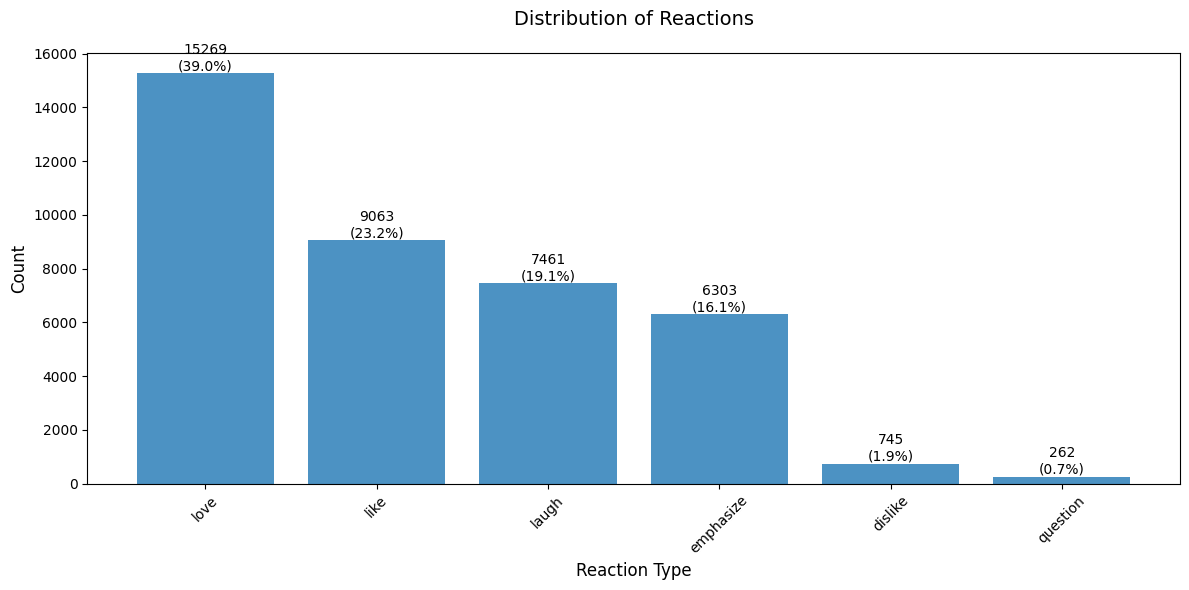

In [ ]:
plt.figure(figsize=(12, 6))

plt.bar(reaction_dist['label'], reaction_dist['count'], alpha=0.8)

plt.title('Distribution of Reactions', fontsize=14, pad=20)
plt.xlabel('Reaction Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(reaction_dist['count']):
    plt.text(i, v, f'{v}\n({reaction_dist["percentage"][i]:.1f}%)',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

We have pretty strong class-wise showing from the top k=4 classes, but dislike and question reactions will be undersampled. We could exclude those, or augment the dataset, or take subsamples from the more popular classes to create a better data distribution, but for the purposes of this project I will not be doing that.

This makes me hypothesize that the model will not predict many dislikes or questions, if at all. But that is okay with me for the scope of this project.


In [ ]:
%%bigquery time_dist --project $project_id

SELECT
 DATE_TRUNC(TIMESTAMP(TextDate), MONTH) as month,
 COUNT(*) as count,
 label
FROM `cs145-project1-receipts.texts_dataset.messages_with_reactions`
GROUP BY month, label
ORDER BY month

Query is running:   0%|          |

Downloading:   0%|          |

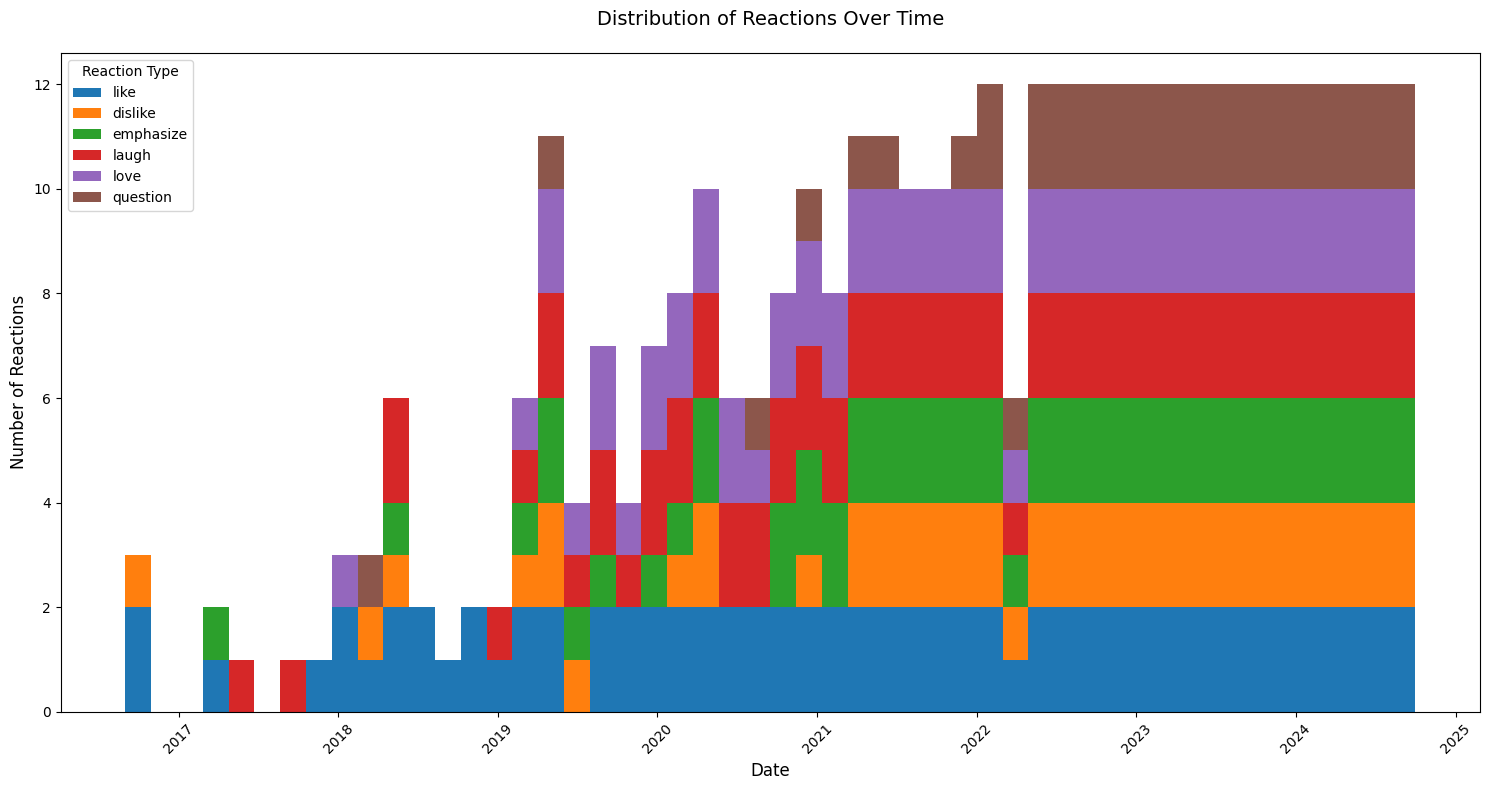


Monthly Statistics:
Average reactions per month: 460.0
Maximum reactions in a month: 2261
Minimum reactions in a month: 1


In [ ]:
time_dist['month'] = pd.to_datetime(time_dist['month'])

plt.figure(figsize=(15, 8))

plt.hist([time_dist[time_dist['label'] == label]['month'] for label in time_dist['label'].unique()],
         bins=50,  # adjust number of bins as needed
         label=time_dist['label'].unique(),
         stacked=True)

plt.title('Distribution of Reactions Over Time', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Reactions', fontsize=12)
plt.legend(title='Reaction Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nMonthly Statistics:")
monthly_total = time_dist.groupby('month')['count'].sum()
print(f"Average reactions per month: {monthly_total.mean():.1f}")
print(f"Maximum reactions in a month: {monthly_total.max()}")
print(f"Minimum reactions in a month: {monthly_total.min()}")

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from google.cloud import bigquery

# First, get the data
query = """
SELECT
   rowid,
   MessageText
FROM `cs145-project1-receipts.texts_dataset.messages_with_reactions`
"""

# Execute query and get data
client = bigquery.Client(project='cs145-project1-receipts')
df = client.query(query).to_dataframe()

# Create TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000, min_df=3)
tfidf_matrix = vectorizer.fit_transform(df['MessageText'])

# Convert to DataFrame with feature names
tfidf_df = pd.DataFrame(
   tfidf_matrix.toarray(),
   columns=vectorizer.get_feature_names_out(),
   index=df['rowid']
).reset_index()

# Melt the DataFrame to get it into a format for BigQuery
# This will create rows with rowid, word, and tfidf_score
tfidf_long = tfidf_df.melt(
   id_vars=['rowid'],
   var_name='word',
   value_name='tfidf_score'
).query('tfidf_score > 0')  # Only keep non-zero values to save space

# Save to BigQuery
destination_table = 'cs145-project1-receipts.texts_dataset.tfidf_features'
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
client.load_table_from_dataframe(tfidf_long, destination_table, job_config=job_config)

LoadJob<project=cs145-project1-receipts, location=US, id=eb2a2dd6-f6f6-4485-ab76-aa731861d86c>

In [16]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `cs145-project1-receipts.texts_dataset.messages_with_reactions_final` AS
SELECT
   m.IsFromMe,
   m.TextDate,
   m.MessageText,
   m.RoomName,
   m.ContactName,
   m.positive,
   m.negative,
   m.neutral,
   m.gender,
   m.label,
   m.message_length,
   m.word_count,
   m.has_question,
   m.has_exclamation,
   m.emoji_count,
   m.hour_of_day,
   m.day_of_week,
   m.is_weekend,
   m.month,
   ARRAY_AGG(STRUCT(t.word, t.tfidf_score) ORDER BY t.tfidf_score DESC) as tfidf_features
FROM
   `cs145-project1-receipts.texts_dataset.messages_with_reactions` m
LEFT JOIN
   `cs145-project1-receipts.texts_dataset.tfidf_features` t
ON
   m.rowid = t.rowid
GROUP BY
   m.IsFromMe,
   m.TextDate,
   m.MessageText,
   m.RoomName,
   m.ContactName,
   m.positive,
   m.negative,
   m.neutral,
   m.gender,
   m.label,
   m.message_length,
   m.word_count,
   m.has_question,
   m.has_exclamation,
   m.emoji_count,
   m.hour_of_day,
   m.day_of_week,
   m.is_weekend,
   m.month

Query is running:   0%|          |

In [31]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `cs145-project1-receipts.texts_dataset.reaction_model_data` AS
SELECT
    label,
    IsFromMe,
    RoomName,
    ContactName,
    gender,
    message_length,
    word_count,
    has_question,
    has_exclamation,
    emoji_count,
    hour_of_day,
    day_of_week,
    is_weekend,
    month,
    positive,
    negative,
    neutral,
    RAND() < 0.70 AS is_training_data  -- TRUE for training (70%), FALSE for evaluation (30%)
FROM `cs145-project1-receipts.texts_dataset.messages_with_reactions_final`;

Query is running:   0%|          |

""


In [24]:
%%bigquery split_dist --project $project_id

SELECT
 data_split,
 label,
 COUNT(*) as count,
 COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY data_split) as percentage
FROM
 `cs145-project1-receipts.texts_dataset.reaction_model_data`
GROUP BY
 data_split, label
ORDER BY
 data_split, count DESC

Query is running:   0%|          |

Downloading:   0%|          |

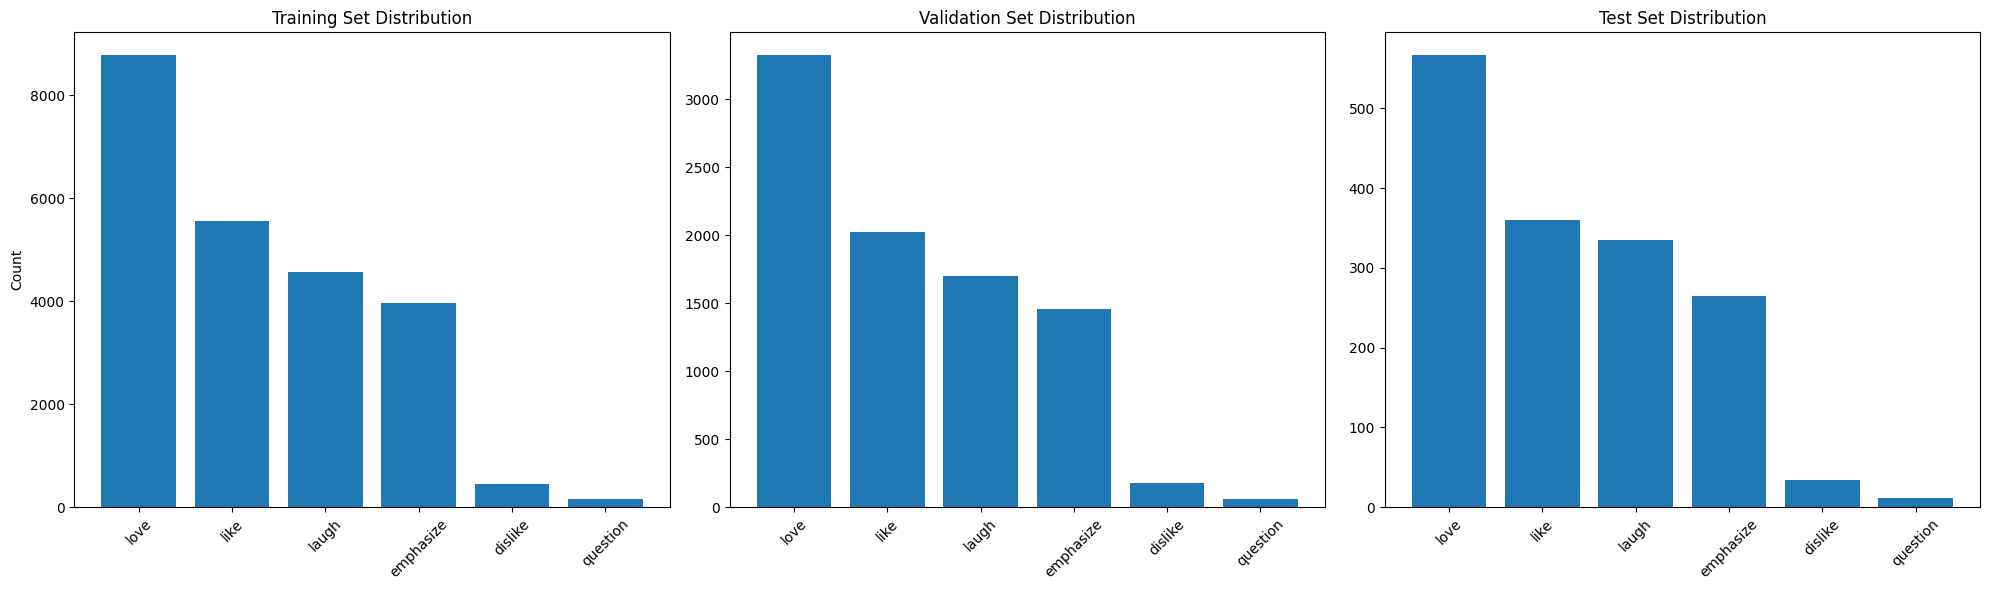

In [25]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Get data for each split
train_data = split_dist[split_dist['data_split'] == 'TRAIN']
val_data = split_dist[split_dist['data_split'] == 'VALIDATION']
test_data = split_dist[split_dist['data_split'] == 'TEST']

# Plot training data
ax1.bar(train_data['label'], train_data['count'])
ax1.set_title('Training Set Distribution')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Count')

# Plot validation data
ax2.bar(val_data['label'], val_data['count'])
ax2.set_title('Validation Set Distribution')
ax2.tick_params(axis='x', rotation=45)

# Plot test data
ax3.bar(test_data['label'], test_data['count'])
ax3.set_title('Test Set Distribution')
ax3.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [51]:
%%bigquery --project $project_id

-- Create the model
CREATE OR REPLACE MODEL `cs145-project1-receipts.texts_dataset.reaction_prediction_model`
OPTIONS (
    model_type='LOGISTIC_REG',
    input_label_cols=['label'],
    data_split_col='is_training_data',
    data_split_method='CUSTOM',
    auto_class_weights=TRUE,
    enable_global_explain=TRUE
) AS
SELECT
    label,
    IsFromMe,
    RoomName,
    ContactName,
    gender,
    message_length,
    word_count,
    has_question,
    has_exclamation,
    emoji_count,
    hour_of_day,
    day_of_week,
    is_weekend,
    month,
    positive,
    negative,
    neutral,
    is_training_data
FROM `cs145-project1-receipts.texts_dataset.reaction_model_data`

Query is running:   0%|          |

""


In [52]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs145-project1-receipts.texts_dataset.reaction_prediction_model`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,5,0.237301,0.260433,1.6,6312
1,0,4,0.239395,0.260592,3.2,6785
2,0,3,0.251732,0.265308,1.6,7248
3,0,2,0.270575,0.278374,0.8,6513
4,0,1,0.284930,0.289005,0.4,6377
5,0,0,0.293595,0.295221,0.2,4788


In [53]:
%%bigquery --project $project_id

SELECT
 *
FROM ML.EVALUATE(MODEL `cs145-project1-receipts.texts_dataset.reaction_prediction_model`,
(
 SELECT
   label,
   IsFromMe,
   RoomName,
   ContactName,
   gender,
   message_length,
   word_count,
   has_question,
   has_exclamation,
   emoji_count,
   hour_of_day,
   day_of_week,
   is_weekend,
   month,
   positive,
   negative,
   neutral,
   is_training_data
 FROM `cs145-project1-receipts.texts_dataset.reaction_model_data`
 WHERE NOT is_training_data  -- evaluate on test set
))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.361061,0.481237,0.422134,0.33505,1.369655,0.797773


In [54]:
%%bigquery confusion_matrix --project $project_id

SELECT
  *
FROM ML.CONFUSION_MATRIX(MODEL `cs145-project1-receipts.texts_dataset.reaction_prediction_model`,
(
  SELECT
    label,
    IsFromMe,
    RoomName,
    ContactName,
    gender,
    message_length,
    word_count,
    has_question,
    has_exclamation,
    emoji_count,
    hour_of_day,
    day_of_week,
    is_weekend,
    month,
    positive,
    negative,
    neutral,
    is_training_data
  FROM `cs145-project1-receipts.texts_dataset.reaction_model_data`
  WHERE NOT is_training_data
))

Query is running:   0%|          |

Downloading:   0%|          |

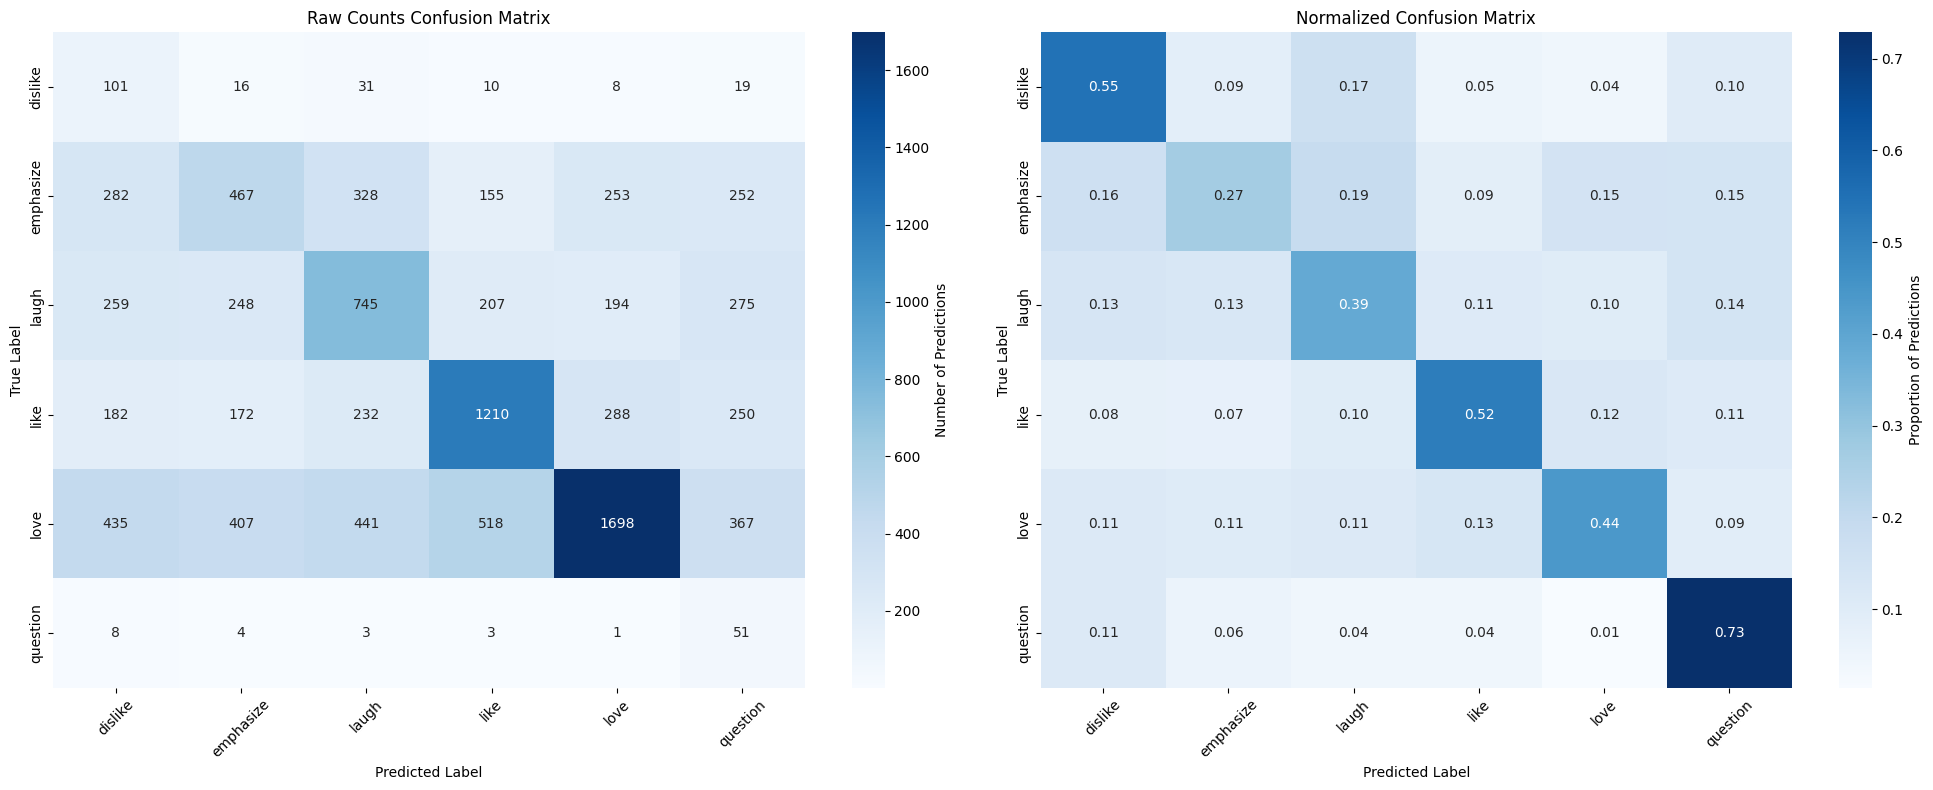


Classwise Accuracy:
dislike: 54.6% (101/185)
emphasize: 26.9% (467/1737)
laugh: 38.6% (745/1928)
like: 51.8% (1210/2334)
love: 43.9% (1698/3866)
question: 72.9% (51/70)


In [55]:
labels = ['dislike', 'emphasize', 'laugh', 'like', 'love', 'question']

conf_matrix = np.zeros((len(labels), len(labels)))
for i, true_label in enumerate(labels):
   true_cases = confusion_matrix[confusion_matrix['expected_label'] == true_label]
   for j, pred_label in enumerate(labels):
       conf_matrix[i, j] = true_cases[pred_label].iloc[0] if not true_cases.empty else 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

conf_df = pd.DataFrame(conf_matrix,
                     index=labels,
                     columns=labels)

sns.heatmap(conf_df,
           annot=True,
           fmt='g',
           cmap='Blues',
           cbar_kws={'label': 'Number of Predictions'},
           ax=ax1)

ax1.set_title('Raw Counts Confusion Matrix')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.tick_params(axis='x', rotation=45)

# Normalized matrix (row-wise to show proportions for each true label)
row_sums = conf_matrix.sum(axis=1)
norm_conf_matrix = conf_matrix / row_sums[:, np.newaxis]
norm_conf_df = pd.DataFrame(norm_conf_matrix,
                         index=labels,
                         columns=labels)

sns.heatmap(norm_conf_df,
           annot=True,
           fmt='.2f',
           cmap='Blues',
           cbar_kws={'label': 'Proportion of Predictions'},
           ax=ax2)

ax2.set_title('Normalized Confusion Matrix')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print class-wise accuracy
print("\nClasswise Accuracy:")
for i, label in enumerate(labels):
   correct = conf_matrix[i, i]
   total = conf_matrix[i].sum()
   accuracy = correct/total * 100 if total > 0 else 0
   print(f"{label}: {accuracy:.1f}% ({int(correct)}/{int(total)})")

Citation: Used Claude to create the normalized confusion matrix and also to use the Seaborn library to make the nice visualization after I made the original matrices in just a 2D list format.

I used logistic regression on multiple classes to predict the types of reactions a message might receive given a variety of input features (shown in queries above). I decided to leverage the usefulness of my supplementary data as the final model, while treading the prediction task on the original data as the baseline. My results supported my original hypothesis, by including information about sentiment and gender of the text, we see improvements across the board (in every single evaluation statistic, as well as stronger results in the confusion matrices), showing that this feature engineering proved to be useful. I consider this feature engineering since these were generated supplementary features that were not simply added as additional datapoints from auxiliary datasets. View the summary statistics here:

**Performance before sentiment, gender data**
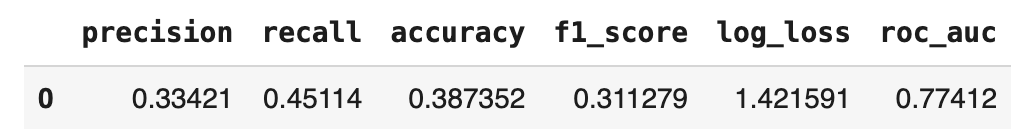
**Performance after sentiment, gender data**
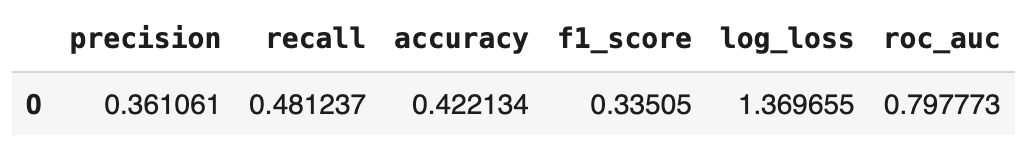

We also see, in the confusion matrix above, that despite the class balance, the model (set to use adaptive weights) ended up not skewing heavily towards overrepresented classes. There was a higher incidence of confusion rate amongst smaller classes, which makes sense not only from a data perspective but also a usage perspective. For example, dislikes and questions have common collateral. We see this to be true also in cases like likes and loves, which can often display the same direction of intent, at differing magnitudes.

## Query Plan Analysis

### 1) Initial supplementary table joins
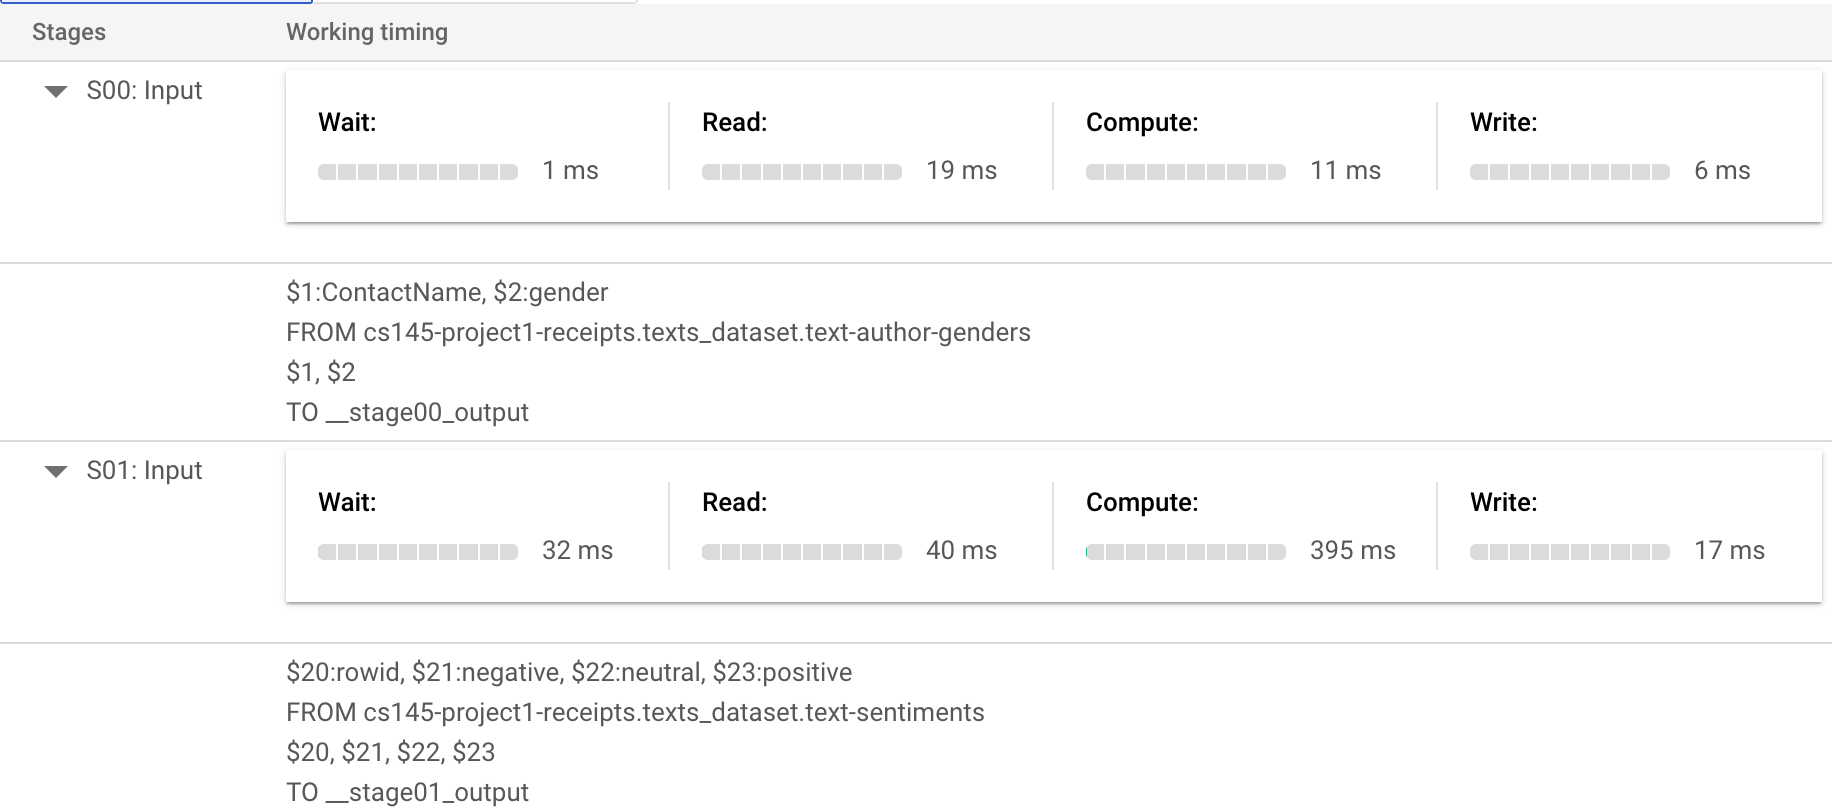
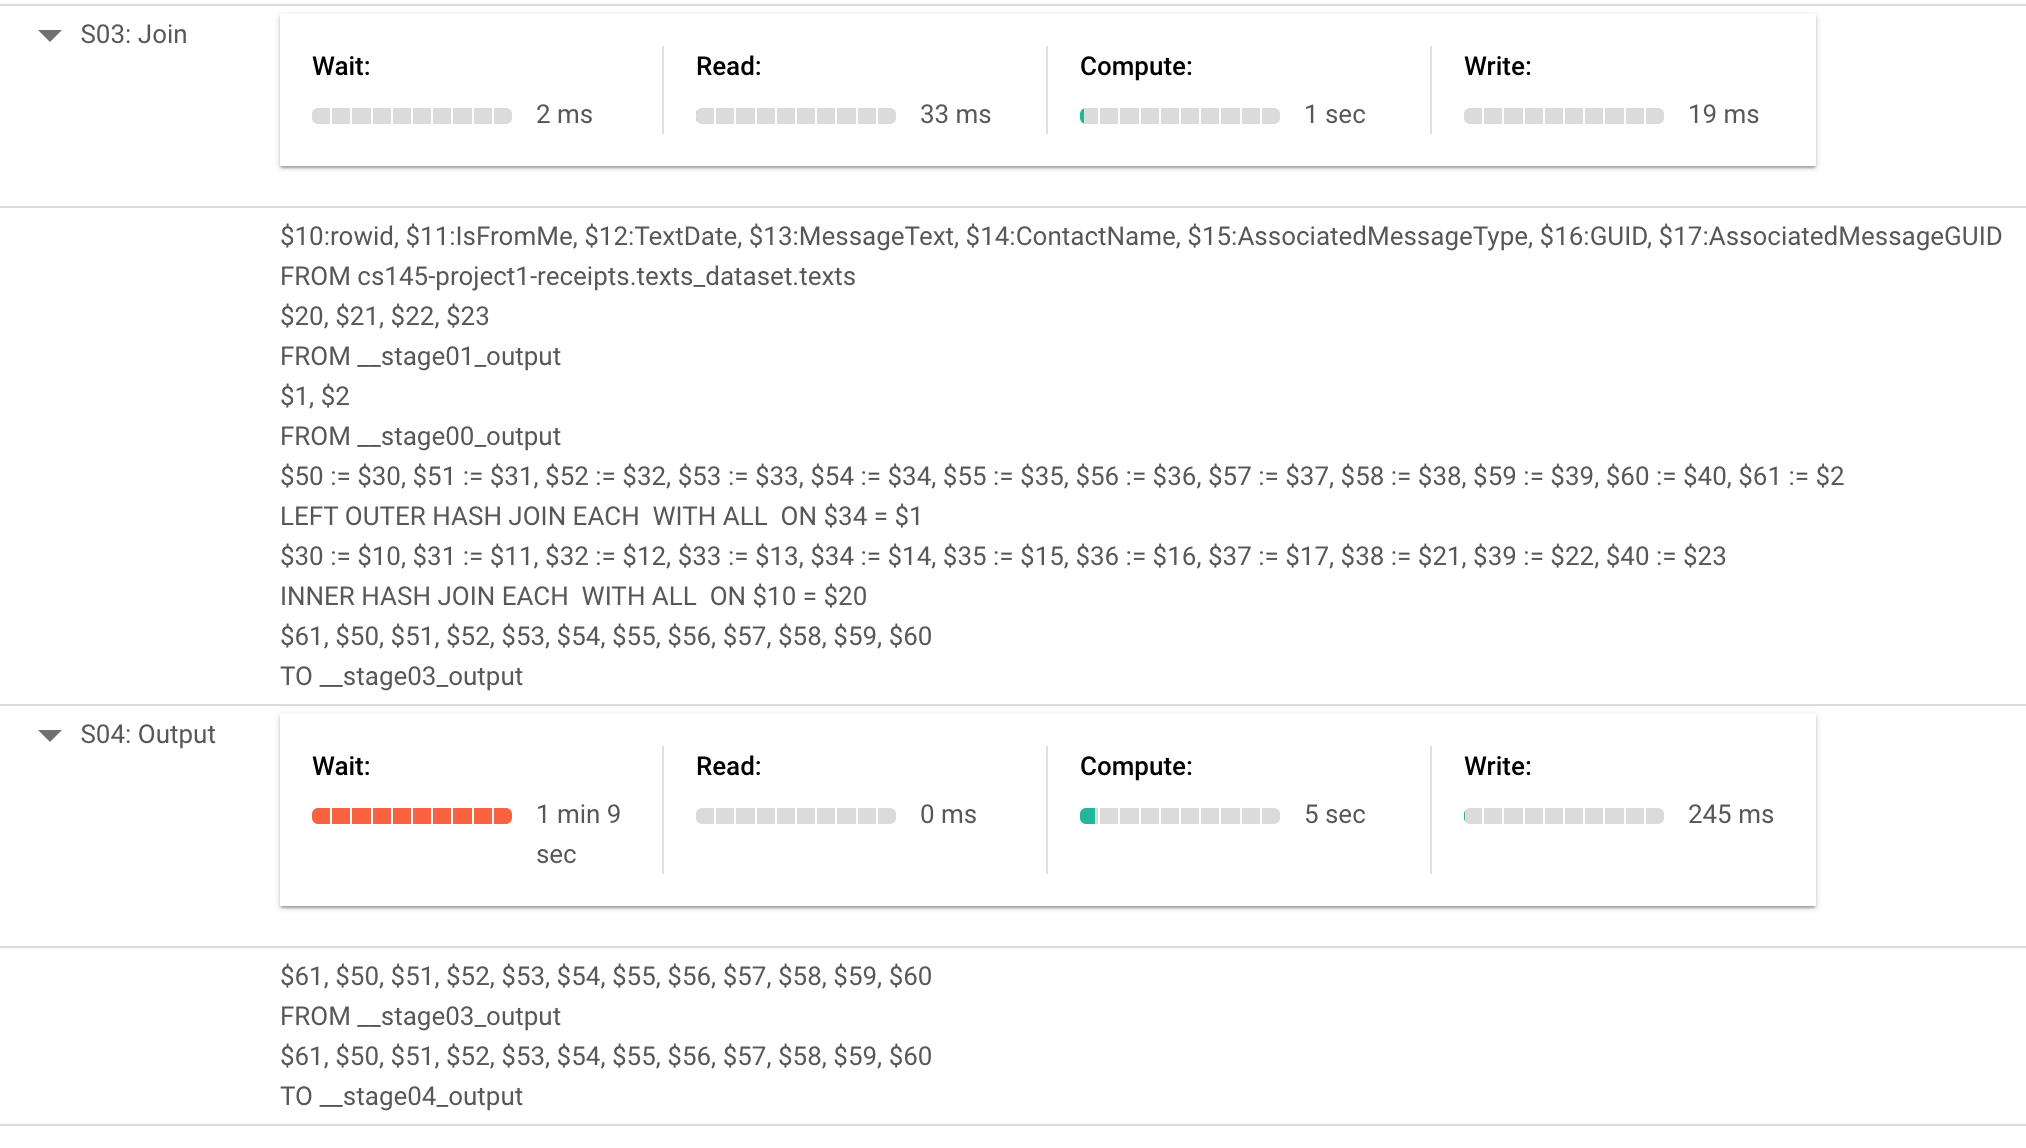

```
SELECT
  t.rowid,
  t.IsFromMe,
  t.TextDate,
  t.MessageText,
  t.ContactName,
  t.AssociatedMessageType,
  t.GUID,
  t.AssociatedMessageGUID,
  s.negative,
  s.positive,
  s.neutral,
  g.gender
FROM
  `cs145-project1-receipts.texts_dataset.texts` t
-- keep all texts for which we computed sentiments
JOIN
  `cs145-project1-receipts.texts_dataset.text-sentiments` s
ON
  t.rowid = s.rowid
-- show null for gender if it does not exist for a contact, but keep left table
LEFT JOIN
  `cs145-project1-receipts.texts_dataset.text-author-genders` g
ON t.ContactName = g.ContactName
```

**Analysis**

Stages S00 and S01 are the input read stages, pulling in our data from the two supplementary datasets. The cost grows linearly with data size. Stage S03 is the joins stage, including the left outer hash join and the inner hash join, which are resource intensive, especially the larger the data gets. Stages S04 is the output write stage to storage, also scaling linearly depending on output size. We see a bottleneck in S04 during output write.

**Efficiency and Improvements**

Since one of the datasets will always be significantly smaller (`text-author-genders`) compared to the sizes of the other datasets, were this to scale massively, it would be prudent to use broadcast joins instead of hash joins to reduce memory and computation needs. We could have also done a better job by creating proper indexes for each of the datasets rather than the various joins on different columns, using join keys can optimize the hash join performance. For larger datasets, we can also take a sharding approach, where we break down the queries into smaller, sharded queries using temporary tables for storage to reduce bottlenecks at particular stages.

### 2) Data feature extraction
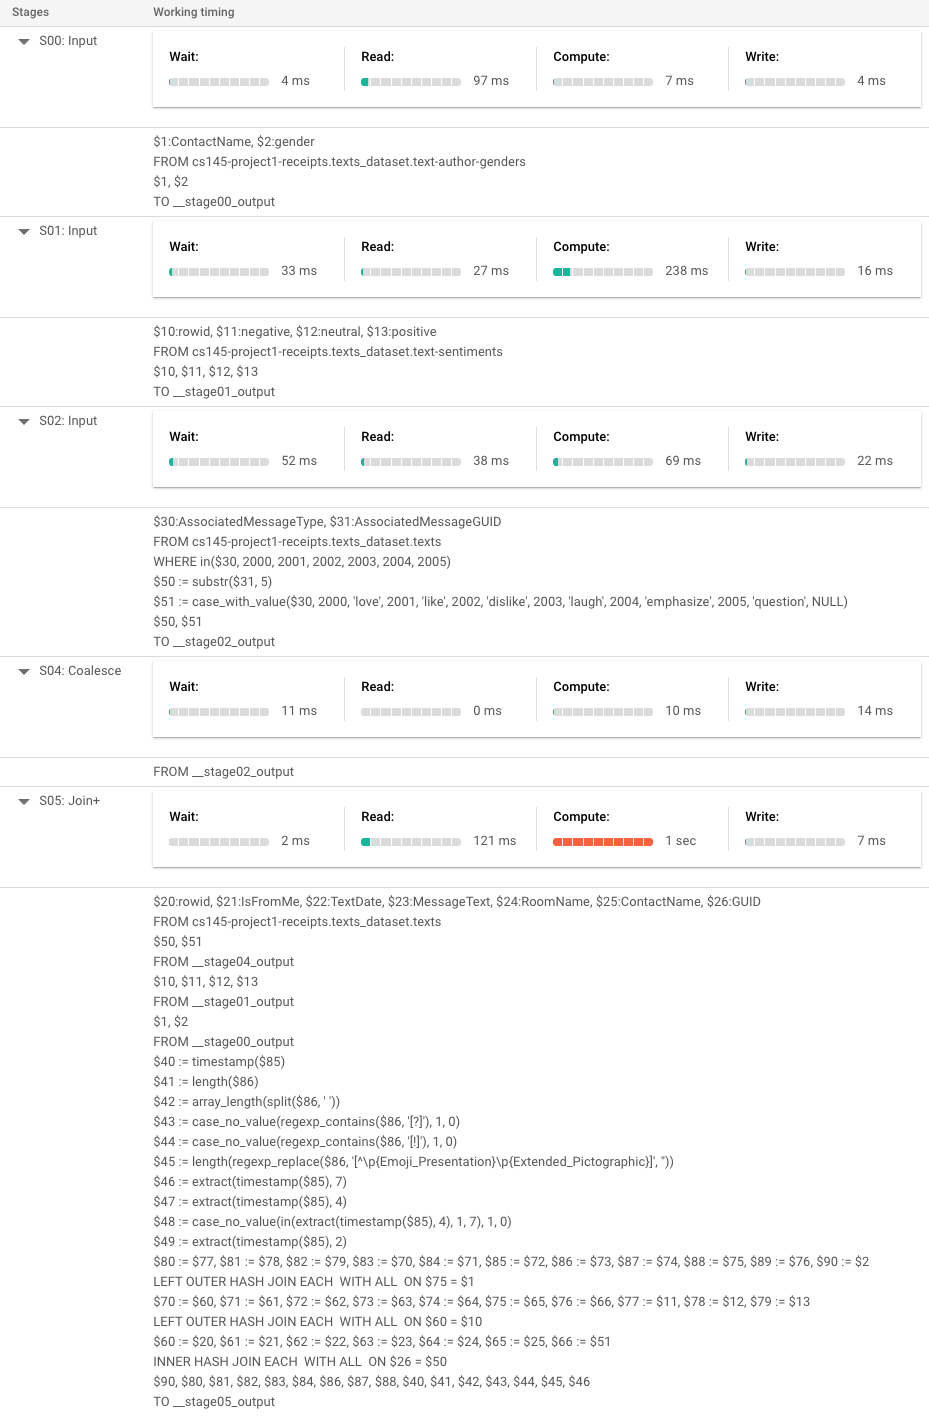
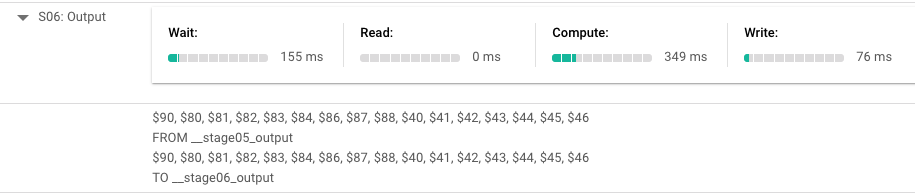

```
WITH reactions_mapping AS (
  SELECT
    SUBSTR(AssociatedMessageGUID, 5) as original_message_guid,
    CASE AssociatedMessageType
      WHEN 2000 THEN 'love'
      WHEN 2001 THEN 'like'
      WHEN 2002 THEN 'dislike'
      WHEN 2003 THEN 'laugh'
      WHEN 2004 THEN 'emphasize'
      WHEN 2005 THEN 'question'
    END as reaction_type
  FROM `cs145-project1-receipts.texts_dataset.texts`
  WHERE AssociatedMessageType IN (2000, 2001, 2002, 2003, 2004, 2005)
)
SELECT
  t.rowid,  -- Add this for joining later
  t.IsFromMe,
  TIMESTAMP(t.TextDate) as TextDate,
  t.MessageText,
  t.RoomName,
  t.ContactName,
  s.positive,
  s.negative,
  s.neutral,
  g.gender,
  r.reaction_type as label,
  -- Text Features
  LENGTH(t.MessageText) as message_length,
  ARRAY_LENGTH(SPLIT(t.MessageText, ' ')) as word_count,
  CASE WHEN REGEXP_CONTAINS(t.MessageText, r'[?]') THEN 1 ELSE 0 END as has_question,
  CASE WHEN REGEXP_CONTAINS(t.MessageText, r'[!]') THEN 1 ELSE 0 END as has_exclamation,
  LENGTH(REGEXP_REPLACE(t.MessageText, r'[^\p{Emoji_Presentation}\p{Extended_Pictographic}]', '')) as emoji_count,
  -- DateTime Features
  EXTRACT(HOUR FROM TIMESTAMP(t.TextDate)) as hour_of_day,
  EXTRACT(DAYOFWEEK FROM TIMESTAMP(t.TextDate)) as day_of_week,
  CASE WHEN EXTRACT(DAYOFWEEK FROM TIMESTAMP(t.TextDate)) IN (1, 7) THEN 1 ELSE 0 END as is_weekend,
  EXTRACT(MONTH FROM TIMESTAMP(t.TextDate)) as month
FROM `cs145-project1-receipts.texts_dataset.texts` t
INNER JOIN reactions_mapping r
  ON t.GUID = r.original_message_guid
LEFT JOIN `cs145-project1-receipts.texts_dataset.text-sentiments` s
  ON t.rowid = s.rowid
LEFT JOIN `cs145-project1-receipts.texts_dataset.text-author-genders` g
  ON t.ContactName = g.ContactName
```

**Analysis**

Stages S00, S01, and S02 handle the input data extraction from the texts, genders, and sentiments table. Stage S02 in particular inovvles filtering and deriving additional fields using various operations (case, substring, etc) which add to computation. Stage S04 performs coalescing, which seems to be efficient over the intermediate results. Stage S05 performs multiple joins and the complex expressions before the join can contribute to slower performance, especially with big data. S06 is the output write, which like the last query, scales linearly depending on the output size.

**Efficiency and Improvements**

To optimize the input stages, ideas include to use partitions over frequently queried fields (in this case `AssociatedMessageType`) to minimize scan costs. For stages like S05, we could also funnel up the where clauses to reuse filtered results earlier on rather than filtering a larger joined table. Again, with smaller tables like the one for gender, we could convert to a broadcast join to reduce memory and computation, especially when scaling up.

## Conclusion

---

**Visualization Takeaways**
I found the visualizations and associated analyses to be extremely insightful. It was very fun to work on this project because the dataset was actually just about me and the nature of my own online communications, so I found out more about myself in the process. I also found it to be fascinating how many of the trends and even the anomalies were highly explainable (i.e. differences and similarities across gender or sentiment), proving to be an exciting extension of the more declaratively statistical outcomes we quantified in Project 1 with the same data.

**ML Predictions Takeaways**
This was super fun to build. It is cool that given a particular message, we can now predict the types of reactions it will get. In a way, it's a more concrete addendum to natural language understanding (NLU) where apart from the message text itself, we see that certain factors can play a role in motivating the selection of reactions as qualifiers (i.e. a funny message gets a laugh, an intent for acknowledgement gets a like, etc).

In the future, I wish I was able to get the TF-IDF processing of the messaging that I did (see above) to work as features for the model. The way in which I structured the data (select top k words, have a structured array entry for salient word usage per message) was not a friendly format for BigQuery ML data ingestion, so I abandoned the effort for the sake of time and scope of the project. I think this could even further enhance the results. Something like Word2Vec embeddings would be similar on this front.

Nevertheless, with an AUROC of nearly 0.80, the performance far outdid my expectations, and was a very interesting quantity to predict after jumping through many hoops to wrangle this dataset into a format that enabled ML analyses.


**Overall Takeaways**

To answer my main question, it is clear that my nature of digital communication has indeed changed over time. This was heavily discussed throughout, and now with the ML model, we can almost forecast the future interactions and how they might be perceived even before others have the chance to react to it. I found this to be extremely fascinating, especially with texting to have been a tool and technology I've grown up with, and to this day drives such a large part of my overall interactions, extending the ones I otherwise would have IRL. There's a lot more work that can be done with quantifying nuance from things like inside jokes, deeper emotions like sarcasm or wit, or cleaning the dataset of junk/spam/out of context messages that would otherwise be detrimental to performance, but regardless, the outcome of this work was very interesting and rewarding!

---